# Excursion

This is an excourse, not really meant to be read again, just me trying out things while reading the book. It is readable, but will include way more of my thoughts in the code thatn usual.

# Excourse on Linear Regression

## Normal Equation

In [22]:
import numpy as np
import matplotlib.pyplot as plt # type: ignore
from matplotlib.figure import Figure # type: ignore
from mpl_toolkits.mplot3d import Axes3D  # type: ignore
from sklearn.preprocessing import add_dummy_feature
from sklearn.metrics import mean_squared_error

# Taken from the function x1 + x2=y
X = np.array([[1,1],[2,2],[3,3]])
y = np.array([[2], [4], [6]])

# Intitialise rng 
rng  = np.random.default_rng(42)

# Will throw error because of perfectly correlated data, let us add some random noise beforehand
# If you add noise to your bias you get some really whacky stuff with gradient descent
X_b_noise = rng.random(size=(3,2))*0.1 
X_b = add_dummy_feature(X_b_noise)


print(X_b)


# So we used y = x1 + x2  to generate the data, let us see how close we get
theta_best = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ y

[[1.         0.0773956  0.04388784]
 [1.         0.08585979 0.0697368 ]
 [1.         0.00941773 0.09756224]]


In [23]:
# We would have hoped for one on both, but we basically get an equivalent feature by theta_2 being approx. 2
# Error is due to the nois
print(f"Theta/ Model Parameters{theta_best}")

# Make predictions for 2 isntances
X_samples_test = np.array([[4,4], [5,5]])
y_test = np.array([[8],[10]])

X_test = add_dummy_feature(X_samples_test)

y_pred = X_test @ theta_best

print(f"Predictions:{y_pred}")
error = mean_squared_error(y_test,y_pred)
print(error)


Theta/ Model Parameters[[-1.50836969]
 [ 1.7874769 ]
 [76.78724959]]
Predictions:[[312.79053628]
 [391.36526277]]
119168.36732462407


We can compute the feature weights (coefficients) and the bias (intercept) in the following way using sklearn and directly using the scipy function that the LinearRegression class is based on. Note that for the calculation of theta we use the pseudoinverse (Moore-Penrose) of X (see Hands on ML). This doesn't seem to be any less accurate, at least for our example, than the closed-form solution (Normal Equation).

The pseudoinverse is always defined, which makes it work on singular matirces as well. The calculation of the pseudoinverse uses Singular Value Decomposition (see Hands on ML)

In [24]:
# Doing it with sklearn
from sklearn.linear_model import LinearRegression

lin_mdl = LinearRegression()

lin_mdl.fit(X_b,y)
y_pred=lin_mdl.predict(X_test)
for i in range(y_pred.shape[0]):
	print(f"Prediction {i}: {y_pred[i,0]:.2f}")
print(y_pred)
# Equivalent terms
bias, weights =  lin_mdl.intercept_,lin_mdl.coef_



Prediction 0: 312.79
Prediction 1: 391.37
[[312.79053628]
 [391.36526277]]


### Implement matrix multiplication, small exercise   

In [25]:
def matrix_mult(A: np.ndarray,B: np.ndarray) -> np.ndarray:
    if not (A.shape[1] == B.shape[0]):
        raise ValueError("Incompatible Matrix Dimensions:{} {}".format(A.shape,B.shape) )

    C = np.zeros((A.shape[0],B.shape[1]))

    for i in range(A.shape[0]):
        for j in range(B.shape[1]):
            C[i,j] = np.sum(A[i,:]*B[:,j])
    
    return C

A = np.array([[1,1,1],[1,1,1],[1,1,1]])
A_test = np.array([[1,1,1],[1,1,1]])
B = np.array([[1,1,1],[1,1,1],[1,1,1]])
B_false = np.array([[1,1,1],[1,1,1]])
B_test = np.array([[1,1],[1,1],[1,1]])

print(matrix_mult(A,B))
try:
    print(matrix_mult(A,B_false))
except:
    print('It failed :(....As expected hahaha <evil> :)')

print(matrix_mult(A,B_test))
print(matrix_mult(A_test,B))




[[3. 3. 3.]
 [3. 3. 3.]
 [3. 3. 3.]]
It failed :(....As expected hahaha <evil> :)
[[3. 3.]
 [3. 3.]
 [3. 3.]]
[[3. 3. 3.]
 [3. 3. 3.]]


# Implement gradient descent    

[[1.         0.84168644]
 [1.         0.41554657]
 [1.         0.76243629]
 [1.         1.2926542 ]
 [1.         1.21388275]
 [1.         1.30594134]
 [1.         1.19157759]
 [1.         0.75634475]
 [1.         1.18763057]
 [1.         0.376384  ]
 [1.         1.12513007]
 [1.         1.49866109]
 [1.         0.8983834 ]
 [1.         0.30772107]
 [1.         1.26674862]
 [1.         1.01197318]
 [1.         0.72024869]
 [1.         1.31653057]
 [1.         1.2352061 ]
 [1.         1.06177358]]


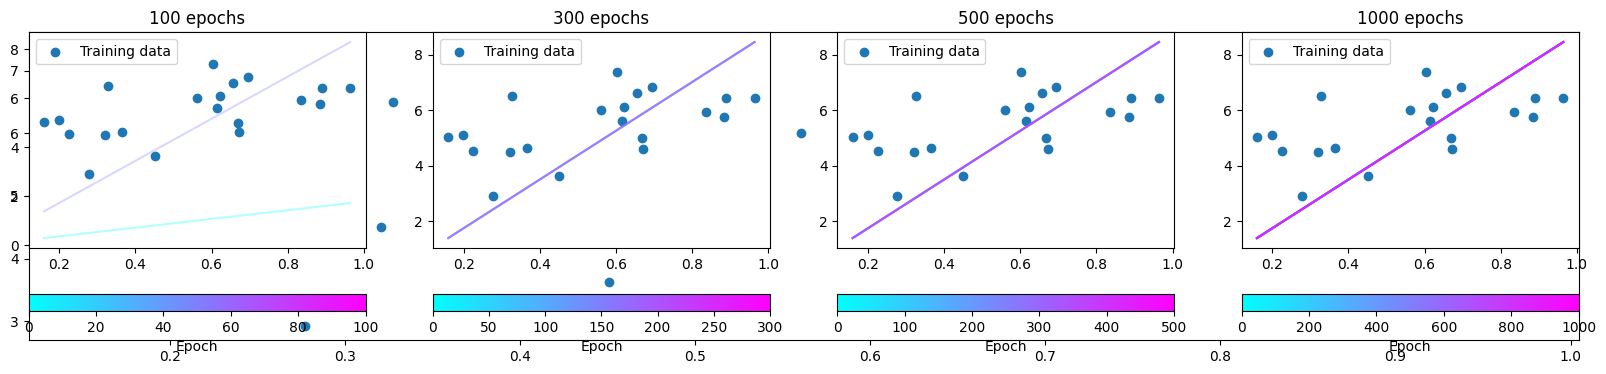

Input Matrix: 
 [[0.19895671]
 [0.22577844]
 [0.65604761]
 [0.32751208]
 [0.61502438]]
Weights: 
 [[8.76975962]]
Predictions: 
 [1.74480254 1.98002262 5.7533798  2.8722022  5.39361599]


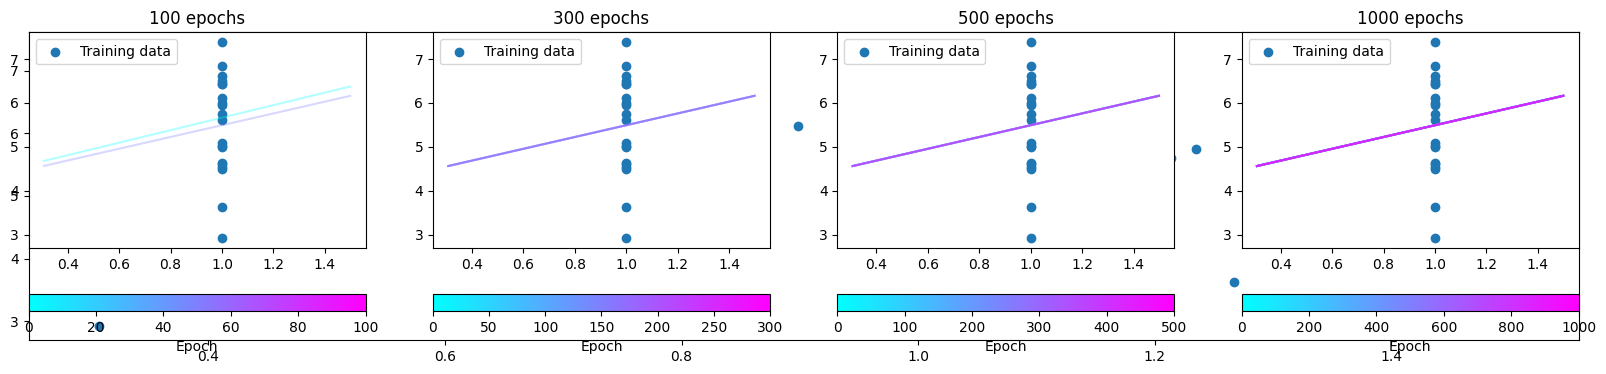

Input Matrix: 
 [[1.         0.84168644]
 [1.         0.41554657]
 [1.         0.76243629]
 [1.         1.2926542 ]
 [1.         1.21388275]]
Weights: 
 [[4.14728367]
 [1.34475943]]
Predictions: 
 [5.27914945 4.70609385 5.17257706 5.88559259 5.77966395]


In [ ]:
import matplotlib
from matplotlib import colormaps


def gradient_descent(n_epochs: int|list, X: np.ndarray, y: np.ndarray, 
                    eta: float, theta: np.ndarray) -> np.ndarray:
    """Performs (batch) gradient descent with live plotting of progression
    
        Doesn't really make sence to plot for multiple epochs, because if our loss function is 
        good then it is guaranteed to get arbitrarily close to the local minimum regardless of 
        the amount of epochs i.e. with more epochs we only grow closer. Furthermore, if it si convex
        we are guaranteed to get arbitrarily close to the global minimum, so plotting for the largest epoch would
        always include the smaller plots. What I shoudl have done was to plot for various learning rates. Oh well
    """
    m = X.shape[0]
    
    # Create figure for visualization
    epochs_list = n_epochs if isinstance(n_epochs, list) else [n_epochs]
    n_plots = len(epochs_list)
    fig = plt.figure(figsize=(n_plots * 5, 4))
    
    for pos, epochs in enumerate(epochs_list):
        # Create subplot for each epoch number
        ax = fig.add_subplot(1, n_plots, pos + 1)
        
        # Plot data points (using correct column)
        data_col = 1 if X.shape[1] > 1 else 0  # Skip dummy column if present
        ax.scatter(X[:, data_col], y[:, 0], label='Training data')
        
        # Add colorbar
        norm = matplotlib.colors.Normalize(vmin=0, vmax=epochs)
        fig.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap="cool"),
                     ax=ax, orientation='horizontal', label='Epoch')
        
        # Run gradient descent for this many epochs
        for i in range(epochs):
            # gradient vector from MSE derivative
            grad_vec = 2 / m * X.T @ (X @ theta - y)
            theta = theta - eta * grad_vec
            
            # Plot progression with color gradient
            if i % 50 == 0:  # Plot every 50th step to avoid clutter
                cool = colormaps['cool']
                color = cool(i / epochs)
                sorted_idx = np.argsort(X[:, data_col])
                ax.plot(X[sorted_idx, data_col],
                        (X @ theta)[sorted_idx],
                        linestyle='solid',
                        color=color,
                        alpha=0.3,
                        label=f'Epoch {i}' if i == epochs - 1 else None)
        ax.set_title(f"{epochs} epochs")
        ax.legend()

    plt.tight_layout()
    plt.show()
    return theta

np.random.seed(42)
m=20
# Instances
X_book = rng.random(size=(m,1))
X_book_noise =  X_book + rng.random(size = X_book.shape)
X_book_b = add_dummy_feature(X_book_noise)
y_book = 4 + 3 * X_book + np.random.randn(m, 1)

print(X_book_b.shape)

for i in [X_book,X_book_b]:
    # Initialize theta for each run
    theta_rand = rng.random((i.shape[1],1)) * 5

    eta=0.1
    # No need to add dummy parameter when using gradient descent apparently
    # Well a dummy parameter (bias) was added by geron, let me add it back
    weights = gradient_descent([100,300,500,1000], i,y_book,eta,theta_rand)
    print(f"Input Matrix: \n {i[:5,:]}")
    print(f"Weights: \n {weights}")
    print(f"Predictions: \n {(i @ weights)[:5,0]}")